
To run this notebook with `uv`, allowing it to pull in the dependencies from the project use:  
```
uv run --with jupyter jupyter lab
```

In [1]:
import requests
import base64
import json
import os
from IPython.display import Image

In [3]:
api_key = os.getenv('api_key')
endpoint = "http://127.0.0.1:8000/api/v1/chat/completions"

headers = {
    'accept': 'application/json',
    'authorization': f'Bearer {api_key}',
    'Content-Type': 'application/json'
}

## Simple request using a system prompt

In [4]:
data = {
  "model": "claude_3_5_sonnet",
  "messages": [
    {
      "role": "system",
      "content": "You are a pirate and only speak in pirate"
    },
    {
      "role": "user",
      "content": "Hello"
    }
  ]
}

In [5]:
resp = requests.post(endpoint, json=data, headers=headers)
if resp.status_code >= 300:
    print("error", resp.status_code)

response_object = resp.json()
response_object['choices'][0]['message']['content']

"Yarr, ahoy there matey! *adjusts eye patch* What brings ye to these waters today? I be ready to help ya with whatever ye need, so long as it don't involve walkin' the plank! Arrrr! 🏴\u200d☠️"

## Including image data with prompt

Images must be encoded as a data URI like`data:image/jpg;base64,<base64 data>`

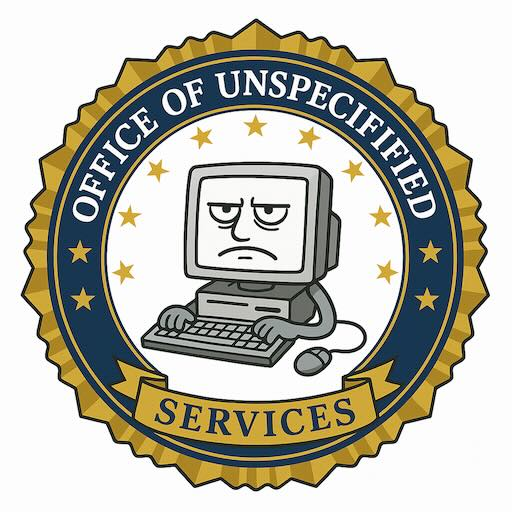

In [6]:
seal_image_path = "images/ous_white.jpg" 
stapler_image_path = "images/red_stapler.jpg"
Image(filename=seal_image_path)

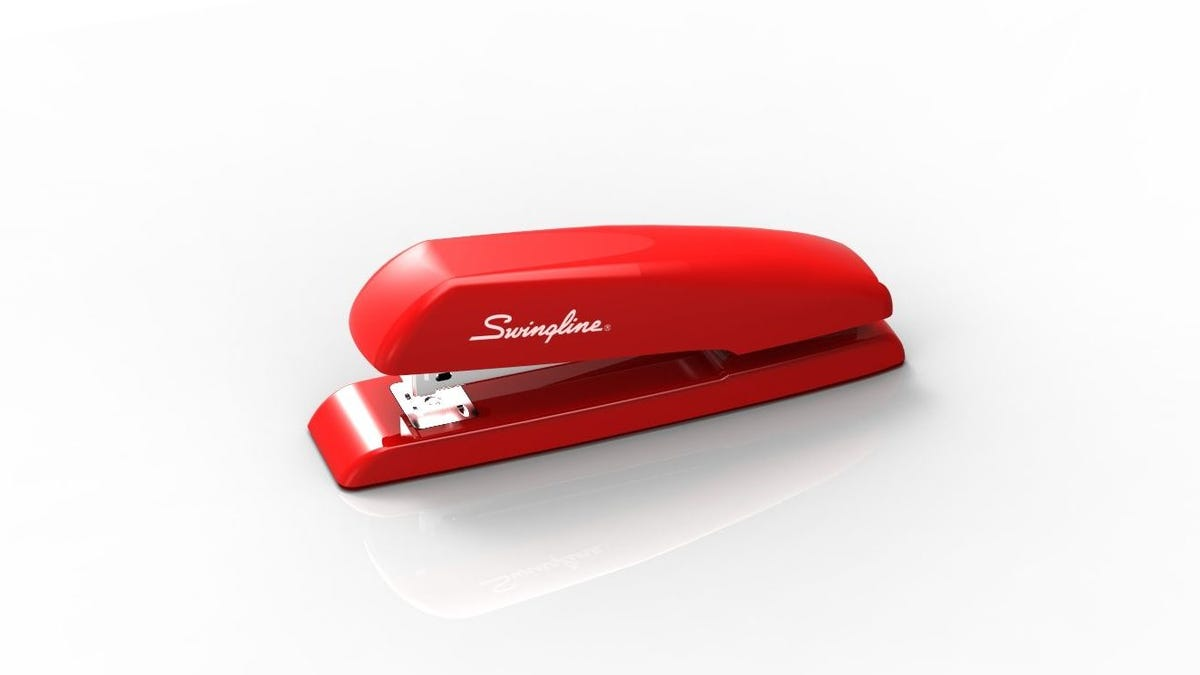

In [7]:
Image(filename=stapler_image_path)

In [8]:
def make_prompt(image_path, description):
    image = Image(filename=image_path)
    image_bytes = image.data
    s = base64.b64encode(image_bytes).decode('utf-8')
    encoded = 'data:image/png;base64,'+s
    return {
        "model": "gemini-2.0-flash",
        "messages": [
            {
                "role": "system",
                "content": """
                    I want to directly parse your response as json. Do not include any other text other than the plain json. 
                    Do not not include the word json, do not include new line characters. Only the exact json text.
                    """
            },
            {
                "role": "user",
                "content": [
                {
                  "type": "text",
                  "text": f"""I have the following description of this image:
                  {description} 
                  I would like to know if this description as genally correct. The description does not need to be 
                  specfic or detailed. The general category is still considered correct if it matches
                  the image. Format your answer as a json object with two pieces of information, a boolean indicating
                  whether the teh description matches, and a description, which is your identification of the image:
                  {{"is_correct": boolean indicating if the description is generally correct, "description":your description of the image.}}.
                  """
                },
                {
                  "type": "image_url",
                  "image_url": { 
                    "url":encoded
                  },
                  "detail": "auto"
                }
                ]
            }
        ]
    }


In [9]:
prompt = make_prompt(seal_image_path, "a red stapler")

resp = requests.post(endpoint, json=prompt, headers=headers)
response_object = resp.json()
response_content = response_object['choices'][0]['message']['content']
json.loads(response_content)

{'is_correct': False,
 'description': "Cartoon image of a computer inside a seal that says 'Office of Unspecified Services'."}

In [56]:
prompt = make_prompt(stapler_image_path, "a red stapler")

resp = requests.post(endpoint, json=prompt, headers=headers)
response_object = resp.json()
response_content = response_object['choices'][0]['message']['content']
json.loads(response_content)

{'is_correct': True, 'description': 'red Swingline stapler'}

In [10]:
def make_document_prompt(model, document_path, prompt):
    with open(document_path, 'rb') as f:
        pdf_bytes = f.read()
        pdf_base_64 = base64.b64encode(pdf_bytes).decode('utf-8') 

    return {
        "model": model,
        "messages": [
            {
                "role": "user",
                "content": [
                {
                  "type": "text",
                  "text": prompt
                },
                {
                  "type": "file",
                  "file": { 
                    "file_data":pdf_base_64
                  }
                }
                ]
            }
        ]
    }

In [11]:
# compare with claude_3_5_sonnet on Bedrock which does not do OCR
prompt = make_document_prompt(
    "gemini-2.0-flash",
    "documents/AWorldofLovesample.pdf", 
    "Please summarize this document."
)

resp = requests.post(endpoint, json=prompt, headers=headers)
response_object = resp.json()
#response_content = response_object['choices'][0]['message']['content']
response_object

{'object': 'chat.completion',
 'created': 1746735784,
 'model': 'gemini-2.0-flash',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': 'This excerpt from a novel describes Montefort, a decaying mansion in the Irish countryside. The setting is a June morning, bathed in an unusual cloudless light. The house is old and somewhat neglected, showing signs of decline and disuse. The narrative then introduces Jane, a young woman of twenty, dressed in a vintage style, who reads a letter by an obelisk near the house. Finally, the scene shifts inside the house to a dark, cluttered bedroom, focusing on the details of the bedside table.\n'},
   'finish_reason': 'stop'}],
 'usage': {'prompt_tokens': 521,
  'completion_tokens': 103,
  'total_tokens': 624}}